  # Project ML1 
  
 **"" Face Pose Estimation""**
**in This Project we need to**

* Predict angle Rotation "Eyer angle" (yaw ,pitch, roll)   

* analysis Data set is "AFLW2000"  contain  2000 image every image has matlab file that contain numbers of keys like (pt3d_68 ,Pose_Para) to determine by using these keys  angles and features in 2D 

* use this data to train model on all images in dataset and make predict right angle for any image 

* use more than library to determine which is better like (dlib,opencv,mediapipe)




In [1]:
#load mediapipe
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os,cv2,math,dlib,glob,random
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score,RepeatedStratifiedKFold
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
 

#Preprocessing for DataSet (AFLW2000)
Extract features and angles from dataset to use them for training  by using mediapipe


In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

# Loading Mediapipe Library
use it to detemine Landmark detection for faces to make input for each Regression model are points of markers not images




In [4]:
X_mediapipe=[]
Y_mediapipe=[]
Labels_mediapipe=[]

# loading image and its correspinding mat file
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")])
file_names_mat = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])
faceModule = mediapipe.solutions.face_mesh
for filename in file_names_mat:
    with faceModule.FaceMesh(static_image_mode=True) as faces:
            # loading the image
              image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
              # processing the face to extract the landmark points (468 point) for each x,y,z
              results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
              if results.multi_face_landmarks != None: 
                # looping over the faces in the image
                    X = []
                    Y = []
                    face = results.multi_face_landmarks[0]    
                    for landmark in face.landmark:
                        x = landmark.x
                        y = landmark.y
                        # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                        shape = image.shape 
                        relative_x = int(x * shape[1])
                        relative_y = int(y * shape[0])
                        # X_features
                        X.append(relative_x)
                        # Y_features
                        Y.append(relative_y)
                        # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                        #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                        #cv2_imshow(image)
                   # converting the lists to numpy arrays
                    X = np.array(X)
                    Y = np.array(Y)
                    # appending the points of the images in the list of all image points
                   
                    X_mediapipe.append(X)
                    Y_mediapipe.append(Y)     
                    mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
                    # extract angles
                    pose_para = mat_file["Pose_Para"][0][:3]
                    pitch = pose_para[0]
                    yaw = pose_para[1]
                    roll = pose_para[2]
                    angles=np.hstack((pitch, yaw, roll))
                    Labels_mediapipe.append(pose_para)      
                      
                
X_mediapipe=np.array(X_mediapipe)
Y_mediapipe=np.array(Y_mediapipe)
Labels_mediapipe=np.array(Labels_mediapipe)
points_mediapipe=np.hstack([X_mediapipe,Y_mediapipe])
print(X_mediapipe.shape) 
print(points_mediapipe.shape) 
print(Labels_mediapipe.shape)     
            


(1853, 468)
(1853, 936)
(1853, 3)


In [5]:

print("shape of labels",Labels_mediapipe.shape ) 


shape of labels (1853, 3)


#normalize features that get them fom mediapipe

**make all points centralize at fixed point to make axis of image plane fixed where ever the location of face in image and also divide on fixed euclidean distance between two fixed points**

In [6]:
x=points_mediapipe[:,:468]
y=points_mediapipe[:,:468]
X_features_mp = np.array(x)
Y_features_mp = np.array(y)

X_center_features_mp = X_mediapipe - X_mediapipe[:,100].reshape(-1,1)
Y_center_features_mp = Y_mediapipe - Y_mediapipe[:,100].reshape(-1,1)
X_100 = X_mediapipe[:,100]
X_10 = X_mediapipe[:,10]
Y_100 = Y_mediapipe[:,100]
Y_10 = Y_mediapipe[:,10]

# computing the distance
dist = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_100,Y_100)),axis = 0).reshape(-1,1)
X_norm_features_mp = (X_center_features_mp / dist)
Y_norm_features_mp = (Y_center_features_mp / dist)

points_features_mp = np.hstack([X_norm_features_mp,Y_norm_features_mp])
print(points_features_mp.shape)
print(X_features_mp .shape)
print(X_norm_features_mp.shape)
points_features_mp

(1853, 936)
(1853, 468)
(1853, 468)


array([[ 0.24009802,  0.25724788,  0.25724788, ..., -0.13719887,
        -0.24867295, -0.28297267],
       [-0.12329924, -0.27399831, -0.08219949, ..., -0.21919865,
        -0.30139814, -0.34249789],
       [ 0.40581989,  0.42717883,  0.40581989, ..., -0.21358941,
        -0.32038412, -0.34174306],
       ...,
       [ 0.1990757 ,  0.28289705,  0.24098637, ..., -0.09429902,
        -0.06286601, -0.09429902],
       [ 0.26146869,  0.29316186,  0.27731527, ..., -0.14261928,
        -0.22185222, -0.2456221 ],
       [ 0.33129605,  0.32234211,  0.31338816, ..., -0.23280263,
        -0.29548026, -0.33129605]])

#Trainning  on the  points of dataset

In [7]:
# splitting the data

X_train,X_val,y_train,y_val = train_test_split(points_features_mp,Labels_mediapipe,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

#XGBoostRegressor Grid Search


In [8]:
#xg_parameters = {'n_estimators': np.arange(3,10,2),'max_depth': np.arange(1,10,4),'learning_rate': np.arange(0.3,1,0.2)}
xg_parameters={'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# grid search pitch

xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_winner_pitch = xg_gs_pitch.best_estimator_
print("Pitch Winner Model: ",xg_winner_pitch)
print("Train Error: ",MAE(xg_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",MAE(xg_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  XGBRegressor(learning_rate=0.7, n_estimators=7, verbosity=0)
Train Error:  0.09990638567104856
Validation Error:  0.20734791798803281


In [9]:
# grid search yaw

#xg_parameters_yaw = {'n_estimators': np.arange(3,15,3),'max_depth': np.arange(1,10,5),'learning_rate': np.arange(0.2,1,0.12)}
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw) 
xg_winner_yaw = xg_gs_yaw.best_estimator_
print("Yaw Winner Model: ",xg_winner_yaw)
print("Train Error: ",MAE(xg_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",MAE(xg_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=9, verbosity=0)
Train Error:  0.050880571287943197
Validation Error:  0.10716372039457758


In [10]:
# grid search roll
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_winner_roll = xg_gs_roll.best_estimator_
print("Yaw Winner Model: ",xg_winner_roll)
print("Train Error: ",MAE(xg_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",MAE(xg_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=9, verbosity=0)
Train Error:  0.12709741072791467
Validation Error:  0.17370667638826828


#Random Forest Grid Search

In [11]:
rf_parameters = {'n_estimators': np.arange(1,21,3),'max_depth': np.arange(1,19,7)}
# grid search pitch
rf = RandomForestRegressor(random_state=0)
rf_gs_pitch = GridSearchCV(estimator = rf,param_grid = rf_parameters)
rf_gs_pitch.fit(X_train, y_train_pitch)
rf_winner_pitch = rf_gs_pitch.best_estimator_
print("Pitch Winner Model: ",rf_winner_pitch)
print("Train Error: ",MAE(rf_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",MAE(rf_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  RandomForestRegressor(max_depth=15, n_estimators=19, random_state=0)
Train Error:  0.05453859519846284
Validation Error:  0.1427259795885689


In [21]:
#rf_parameters = {'n_estimators': np.arange(6,21,2),'max_depth': np.arange(1,19,8)}
# grid search pitch
rf = RandomForestRegressor(random_state=0)
rf_gs_yaw = GridSearchCV(estimator = rf,param_grid = rf_parameters)
rf_gs_yaw.fit(X_train, y_train_yaw)
rf_winner_yaw = rf_gs_yaw.best_estimator_
print("Pitch Winner Model: ",rf_winner_yaw)
print("Train Error: ",MAE(rf_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",MAE(rf_winner_yaw.predict(X_val),y_val_yaw))

Pitch Winner Model:  RandomForestRegressor(max_depth=15, n_estimators=19, random_state=0)
Train Error:  0.03501305834875928
Validation Error:  0.09382926527914016


In [22]:

# grid search pitch
rf = RandomForestRegressor(random_state=0)
rf_gs_roll = GridSearchCV(estimator = rf,param_grid = rf_parameters)
rf_gs_roll.fit(X_train, y_train_roll)
rf_winner_roll = rf_gs_roll.best_estimator_
print("Pitch Winner Model: ",rf_winner_roll)
print("Train Error: ",MAE(rf_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",MAE(rf_winner_roll.predict(X_val),y_val_roll))

Pitch Winner Model:  RandomForestRegressor(max_depth=8, n_estimators=19, random_state=0)
Train Error:  0.056296584435830375
Validation Error:  0.12824465338837218


#SVR with grid search


In [23]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print("Pitch Winner Model: ",svr_winner_pitch)
print("Train Error: ",MAE(svr_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",MAE(svr_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  SVR(C=100, kernel='poly')
Train Error:  0.08977578112038691
Validation Error:  0.0998326438138937


In [24]:
# grid search yaw
svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print("Yaw Winner Model: ",svr_winner_yaw)
print("Train Error: ",MAE(svr_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",MAE(svr_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  SVR(C=10, kernel='poly')
Train Error:  0.07304094391268989
Validation Error:  0.07230071361035953


In [25]:
# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print("Yaw Winner Model: ",svr_winner_roll)
print("Train Error: ",MAE(svr_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",MAE(svr_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  SVR(C=10)
Train Error:  0.07357118688707548
Validation Error:  0.07555771352869457


#Drawing axis

In [13]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

**using MediaPipe to extract points for test images for Testing**  
 ***Drawing the landmarks of the face**


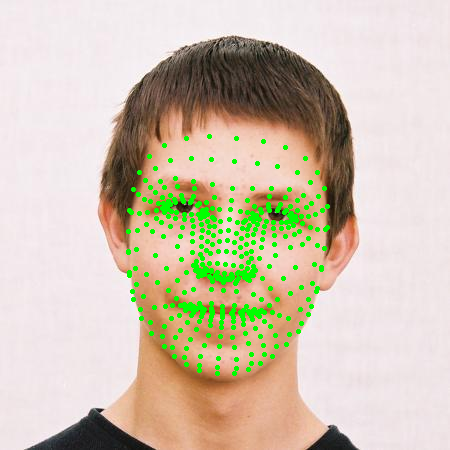

(1, 936)


In [14]:
# choosing random image
#random_file = 'image00053'
X_mediapipe=[]
Y_mediapipe=[]
Labels_mediapipe=[]
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
#file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")])
#file_names_mat = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])
random_file = 'image00050'
# reading the image
fram='/content/AFLW2000/' + random_file + '.jpg'

with faceModule.FaceMesh(static_image_mode=True) as faces:
    
          image = cv2.imread(fram)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
                face = results.multi_face_landmarks[0]
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    X_mediapipe.append( relative_x)
                    relative_y = int(y * shape[0])
                    Y_mediapipe.append(relative_y)
                    # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                   
          cv2_imshow(image)
X_mp =np.array(X_mediapipe)
Y_mp=np.array(Y_mediapipe)
points_test_mediapipe=np.hstack([X_mp,Y_mp]).reshape(1,-1) 
          #print("no thing")
print(points_test_mediapipe.shape)       
         

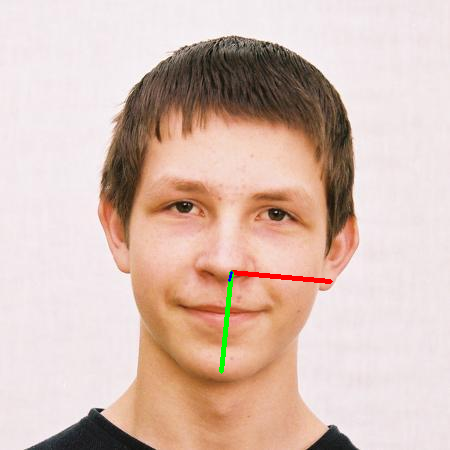

In [15]:


random_file = 'image00050'
# reading the image
image='/content/AFLW2000/' + random_file + '.jpg'
frame = cv2.imread(image)
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/' + random_file + '.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(frame,pitch,yaw,roll,X[1],Y[1]))

**Normalize Test Data**

In [16]:
#x=points_test_mediapipe[:,:468]
#y=points_test_mediapipe[:,:468]
#X_mp = np.array(x)
##Y_mp = np.array(y)
X_100 = X_mp [100]
X_10 =  X_mp[10]
Y_100 = Y_mp[100]
Y_10 = Y_mp[10]
# computing the distance
X_center_mp = X_mp - X_mp[100].reshape(-1,1)
Y_center_mp = Y_mp - Y_mp[100].reshape(-1,1)
dist1 = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_100,Y_100)),axis = 0).reshape(-1,1)
X_norm_features_mp = (X_center_mp / dist1)
Y_norm_features_mp = (Y_center_mp / dist1)
points_mp = np.hstack([X_norm_features_mp,Y_norm_features_mp]).reshape(1,-1)
points_mp

array([[ 0.26784647,  0.2857029 ,  0.27677468,  0.24106182,  0.29463111,
         0.30355933,  0.33034398, -0.21427717,  0.34820041,  0.35712862,
         0.39284148,  0.26784647,  0.26784647,  0.26784647,  0.26784647,
         0.26784647,  0.25891825,  0.25891825,  0.24999004,  0.2857029 ,
         0.21427717, -0.47319542,  0.        , -0.07142572, -0.15177966,
        -0.24999004,  0.07142572, -0.08928216, -0.00892822, -0.16070788,
        -0.21427717, -0.32141576, -0.05356929, -0.24106182, -0.54462115,
        -0.4017697 , -0.09821037,  0.1696361 ,  0.1696361 ,  0.06249751,
        -0.01785643,  0.08928216,  0.02678465, -0.1160668 ,  0.22320539,
         0.22320539, -0.33034398,  0.08035394,  0.03571286,  0.03571286,
        -0.33034398,  0.2321336 , -0.13392323, -0.24999004, -0.38391327,
         0.19642074,  0.06249751, -0.17856431, -0.52676472,  0.08928216,
         0.15177966, -0.10713859, -0.07142572, -0.2857029 ,  0.02678465,
         0.01785643,  0.00892822, -0.05356929, -0.3

#Testing the models on images from the datasets and comparing their results with the true labels


**test on xgboost with grid search**




In [17]:
pitch_out_xg=xg_winner_pitch.predict(points_mp) 
yaw_out_xg=xg_winner_yaw.predict(points_mp)
roll_out_xg=xg_winner_roll.predict(points_mp)

**test on random forst  grid search**

In [26]:
pitch_out_rf=rf_winner_pitch.predict(points_mp) 
yaw_out_rf=rf_winner_yaw.predict(points_mp)
roll_out_rf=rf_winner_roll.predict(points_mp)

**test on SVR with grid search**

In [27]:
pitch_out_svr=svr_winner_pitch.predict(points_mp) 
yaw_out_svr=svr_winner_yaw.predict(points_mp)
roll_out_svr=svr_winner_roll.predict(points_mp)

**draw axis** 

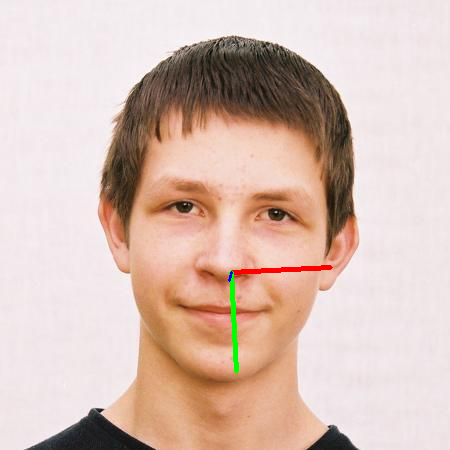

In [18]:
random_file = 'image00050'
# reading the image
image='/content/AFLW2000/' + random_file + '.jpg'
frame = cv2.imread(image)
cv2_imshow(draw_axis(frame,pitch_out_xg,yaw_out_xg,roll_out_xg,X[1],Y[1]))

#Testing the models on test video and drawing the 3 axis by using mediapipe



*   video is more stable and accurate result  by using XGboost model or svr model 
 




In [19]:
cap = cv2.VideoCapture('/content/WIN_20220612_22_39_45_Pro.mp4')
img_array=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
            #frame = cv2.flip(frame,0)
            with faceModule.FaceMesh(static_image_mode=True) as face:
              # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
              results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
              if results.multi_face_landmarks != None:
                  for face in results.multi_face_landmarks:
                      # initializing X and Y lists to store the spacial coordinates of the points
                      X = []
                      Y = []
                      # looping over the landmarks to extract x and y
                      for j,landmark in enumerate(face.landmark):
                          x = landmark.x
                          y = landmark.y
                          # retrieve the true values of x and y
                          shape = frame.shape 
                          relative_x = int(x * shape[1])
                          relative_y = int(y * shape[0])
                          X.append(relative_x)
                          Y.append(relative_y)
                    # normalize frames of video
                      X = np.array(X)
                      Y = np.array(Y)
                      # centering the data arround the point 100
                      X_center = X - X[100]
                      Y_center = Y - Y[100]
              
                      d = np.linalg.norm(np.array((X[100],Y[100])) - np.array((X[10],Y[10])))
                      X_norm = X_center/d
                      Y_norm = Y_center/d
                      X_norm = X_norm
                      Y_norm = Y_norm
                      points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                      # predicting the 3 angels to draw the axis on the image
                    
                      pred_pitch = xg_winner_pitch.predict(points)
                      pred_yaw = xg_winner_yaw.predict(points)
                      pred_roll = xg_winner_roll.predict(points)
                      draw_axis(frame,pred_pitch, pred_yaw,pred_roll,X[1],Y[1])
                      img_array.append(frame)

            
    else: 
       break
cap.release()
cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(img_array))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# converting the frames to video
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))
for i in range(len(img_array)):
            out.write(img_array[i])
out.release()



Number of Detected Frames =  340


In [20]:
from google.colab import files
files.download('/content/output.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>